In [2]:
https://paperswithcode.com/paper/detecting-photoshopped-faces-by-scripting

https://arxiv.org/pdf/1906.05856v2.pdf

Авторы хотят разработать модель для обнаружения популярной манипуляции Photoshop — искажения изображения, применяемого к человеческим лицам. По задумке, модель должна не только отвечать на вопрос *было ли отредактировано изображение?*, но и указывать конкретные области манипуляций, а также возвращать изображение в исходный вид. Авторы создают модель с помощью автоматически сгенерированных редактированных в фотошопе изображений и проверяют, может ли она предсказывать с большей точностью, чем человек. Также, они проверяют, может ли модель, обученная на сгенерированных изображениях хорошо работать на реальных, созданных художником редактированных изображениях.


Идея в том, чтобы обучить бинарный классификатор на основе сверточной нейросети распознавать манипуляции фотошопа над изображением. DRN-C-26 используется для бинарной классификации, отвечает на вопрос "было ли это изображение обработано"? Далее авторы обучают модель прогнозирования потока для визуализации поля искажения пикселя, измеряя расстояние между оригинальными и деформированными пикселями каждого тренировочного объекта. Таким образом, зная поле искажение, можно вернуть изображение в исходный вид до редактирования.




Авторы используют большой набор данных реальных изображений лиц из Open Images dataset и Flickr и создают два набора данных подделок: большой, автоматически сгенерированный набор обработанных изображений для обучения модели и меньший набор реальных манипуляций, выполненных художником для теста модели.
Авторы создают скрипт для инструмента Face-Aware Liquify (FAL) в Adobe Photoshop для создания различных манипуляций с лицами, используя встроенную поддержку выполнения JavaScript. FAL представляет манипуляции с использованием 16 параметров, соответствующих семантике более высокого уровня (например, регулировка ширины носа, расстояния между глазами, высоты подбородка и т.д.). Авторы произвольно выбирают набор параметров FAL. Хотя выбор этих параметров вряд ли будет соответствовать изменениям, которые внес бы художник, они утверждают и подтверждают, что случайная выборка пространства будет охватывать пространство “реалистичных” операций. Каждое изображение из набора данных реальных лиц случайным образом изменяется 6 раз. В целом, данные, которые были использованы для обучения, составляют 1,295 млн лиц, 185 тыс. без изменений и 1,1 млн модифицированных. Кроме того, используется по 5 тысяч реальных лиц из открытых изображений и Flickr, половина изображений оригинальные, а остальные модифицированные таким же образом, как и обучающие данные.
 Для оценки качества предсказания на фотографиях, отредактированных человеком, было создано 50 изображений с помощью инструмента FAL и 50 изображений с помощью более инструмента Liquify – кисти, используемой для искажения изображений. 

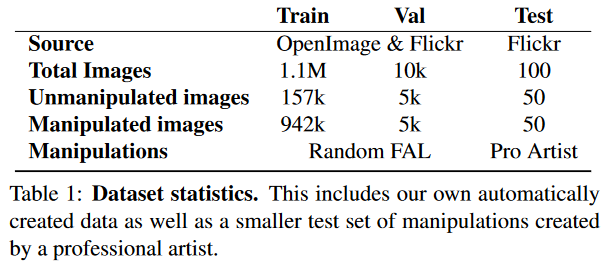


Авторы  обучают бинарный классификатор, используя вариант расширенной остаточной сети (DRN-C-26) 
Dilated Residual Network (DRN) - это тип сверточной нейронной сети, разработанный для решения задачи семантической сегментации. Он является вариантом ResNet (Residual Network) и использует дополнительный механизм расширения поля зрения в сети.

DRN-C-26 - один из вариантов DRN. Он состоит из 26 слоев и имеет конфигурацию, которая включает в себя последовательности сверточных слоев, блоков Residual и блоков Dilated Residual. Блок Residual состоит из двух сверточных слоев и shortcut-соединения, которое позволяет сохранять информацию о предыдущих слоях и предотвращает проблему затухания градиентов. Блок Dilated Residual также содержит shortcut-соединение, но добавляет дополнительный механизм расширения поля зрения, который позволяет учитывать больший контекст изображения при решении задачи сегментации.

Авторы статьи также предлагают метод для восстановления оригинального изображения. Для восстановления оригинального изображения необходимо предсказать поле оптического потока (набор векторов, соответствующих перемещению пикселей изображения) между оригинальным изображением и подвергнутым обработке изображением.


Для этого авторы обучили модель, которая предсказывает поле оптического потока для каждого пикселя и минимизирует ошибку между предсказанным потоком и "истинным" потоком.

$X_{orig} \in \mathbb{R}^{H \times W \times 3}$ - оригинальное изображение, количество пикселей, 3 канала


$\hat{U} \in \mathbb{R}^{H \times W \times 2}$ - поле оптического потока, размерности количества пикселей в изображении, описывает смещение пикселя в 2х направлениях. 


При обучении используется мера ошибки потока - вычисляется с использованием ошибки конечной точки, также известной как EPE (EndPoint Error). EPE измеряет евклидово расстояние между прогнозируемым полем потока и полем истинного потока по всем пикселям изображения.

$\text{Lepe}(F) = ||M*(F(X) - U)||_2^2$ ,  где * - произведение Адамара, поэлементное умножение матриц. $F$ - модель предсказания величины оптического потока (optical flow field), $U$ - "истинный" оптический поток; $X$ - измененное изображение; $M$  представляет собой бинарную маску, которая показывает, какие пиксели измененного изображения были успешно отслежены и имеют корректный оптический поток. 


Получив оптический поток, авторы делают его *гладким*, используя функцию потерь, минимизирующую ошибку между градиентами оптического потока $\nabla_s^x, \nabla_s^y$


$\text{Lms}(F) = \sum\limits_{s \in S} \sum\limits_{t \in {x, y}} ||M(\nabla_s^t(F(X)) - \nabla_s^t(U))||_2^2$

$\nabla_s^x, \nabla_s^y$ - градиенты оптического потока по горизонтали и вертикали, *stride* $s \in {2, 8, 32, 64}$.

Для восстановления исходного изображения из измененного изображения используется обратное преобразование, основанное на корректном поле оптического потока, предсказанном от исходного к измененному изображению. Это приводит к естественной функции потерь реконструкции:

$L_{rec}(F) = \left\vert\left\vert T(X;F(X)) - X_{orig}\right\vert\right\vert_1$ , где $T(X; U)$ производит преобразование изображения $X$ путем пересчета с использованием потока $U$

По результатам экспериментов получается, что суммарная функция потерь выгрядит следующим образом: $L_{\text{total}} = \lambda_e L_{\text{epe}} + \lambda_m L_{\text{ms}} + \lambda_r L_{\text{rec}}$. И дает хорошие результаты при $\lambda_e = 1.5$, $\lambda_m = 15$, и $\lambda_r = 1$ 

Архитектура нейронной сети, используемой в данной работе, основана на варианте Dilated Residual Network (DRN-C-26), который предварительно обучен на датасете ImageNet. DRN была изначально разработана для семантической сегментации, но оказалась эффективной и для задачи предсказания оптического потока.

В данной работе авторы обнаружили, что прямое обучение сети для регрессии потока приводит к плохим результатам. Поэтому они переформулировали задачу предсказания потока в многоклассовую классификацию, которая часто используется в регрессионных задачах. Затем они дообучили сеть на задаче регрессии с потерей.

Для вычисления "истинных" оптических потоков для обучения использовался алгоритм PWC-Net. 

Для $X_{orig}$ и измененного изображения $X_{mod}$ мы вычисляем потоки от оригинала к измененному и от измененного к оригиналу, используя PWC-Net, которые мы обозначаем как $U_{om}$ и $U_{mo}$ соответственно.

Чтобы вычислить маску потока, авторы преобразуют $U_{mo}$ из пространства измененного изображения в пространство оригинального изображения, то есть $U'{mo} = T(U{mo}; U_{om})$. Они считают, что поток согласован в пикселе, если величина $||U'{mo}(p) + U{om}(p)||2 / ||U{om}(p)||_2$ меньше порогового значения. После этого теста пиксели, соответствующие заслонениям и неоднозначностям (например, в областях с низкой текстурой), будут помечены как несогласованные и, следовательно, не будут вносить вклад в потери.


Для каждого пикселя p используется
$Minconsistent(p) = 1 { \frac{||U_{om}(p)||^2}{||U'{mo}(p) + U{om}(p)||^2 + \epsilon} > \tau }$  $\epsilon = 0.1$ и $\tau = 0.85$, затем гауссово размытие с $\sigma = 7$, обозначаемое как $G$, и берем дополнение, чтобы получить маску согласованности потока $M$:

$M = 1 - G(\textrm{Minconsistent})$

**Изображения и поле:**

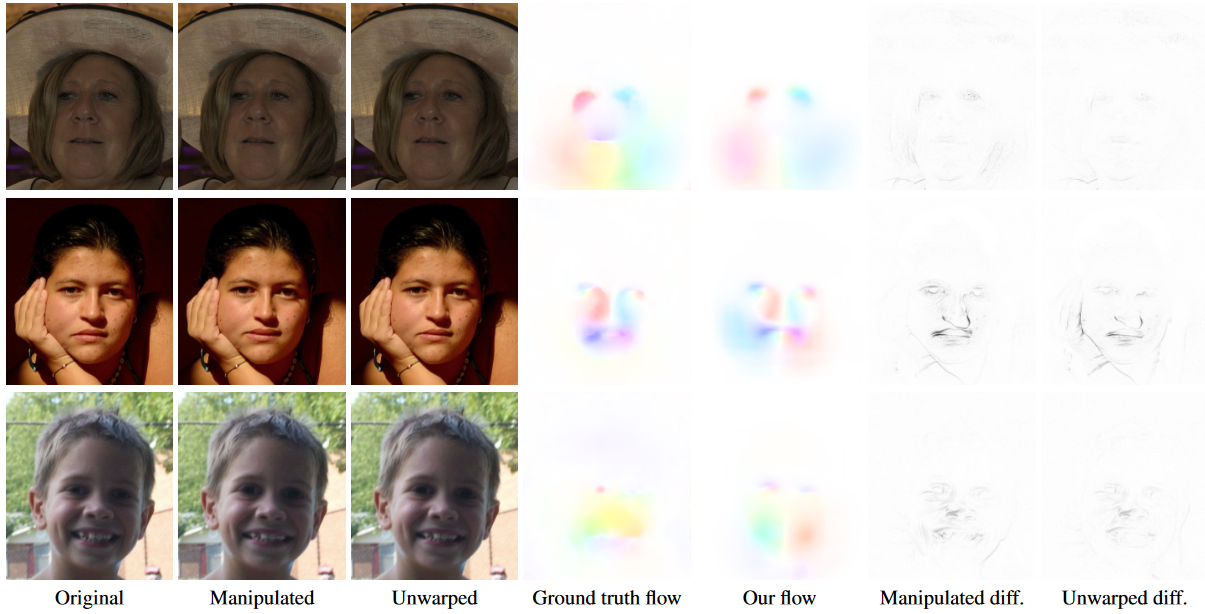

Была проведена оценка точности предсказания модели, для этого использовалась средняя точность (AP) и оценка "Two Alternative Force Choice" (2AFC), которая сравнима с исследованиями на людях, где модели предоставляется два изображения, одно реальное и одно подделанное, и фиксируется изображение которое имеет большую вероятность быть подделкой.

Далее были проведены тесты с различными входными данными, с использованием аугментаций и без, с высоким и низким разрешением изображений.

В сравнении с двумя недавними методами для обработки изображений, FaceForensics++ и Self-consistency обнаружилось что оба метода работают около случайности на используемом наборе данных. Однако предлагаемый метод смог обобщиться на некоторые из наборов данных FaceForensics++ и показать хороший результат распознавание подделок.

Для оценки обратного преобразования используются метрики 
End Point Error (EPE), Intersection Over Union (IOU-τ ), Delta Peak
Signal-to-Noise Ratio (∆PSNR)

Таблицы с результатами:


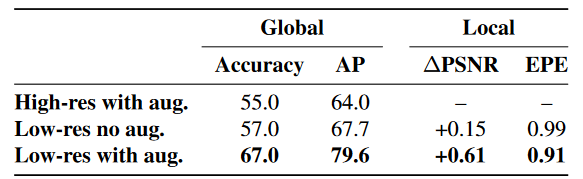

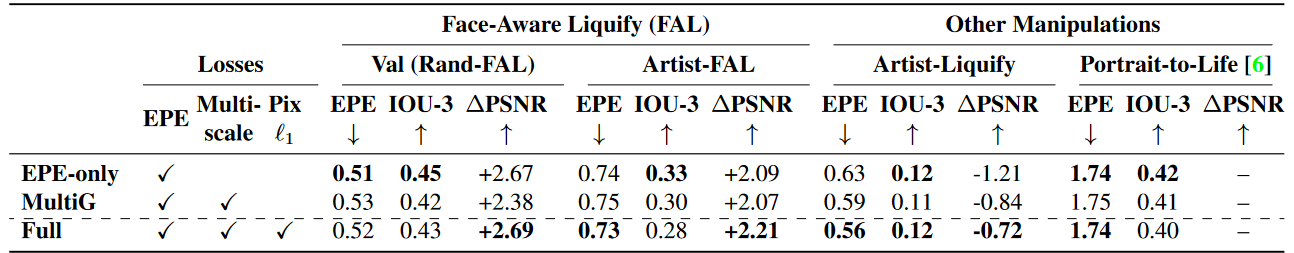

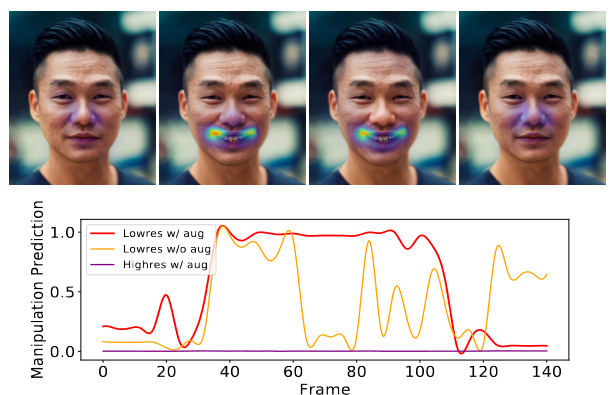

Подводя итог, авторы представили первый метод, предназначенный для обнаружения манипуляции с деформацией, и обучили
криминалистическую модель полностью на автоматически сгенерированных изображениях с помощью инструмента редактирования изображений. В статье показали, что модель
может превзойти человеческие суждения в определении поддельного изображения, и во многих случаях способна определить локальное поле деформации, используемое для создания искривленного изображения.

**Идеи для улучшения:**

Увеличение размера датасета. Для улучшения качества модели можно использовать больше разных данных для обучения. Например, можно собрать больше изображений с разными оптическими потоками, в том числе изображений отредактированных людьми и провести аугментацию, чтобы расширить датасет.


Разграничение различных видов преобразование. Можно разделить 16 видов искажения на группы и обучать для каждой группы возможных преобразований отдельную модель, а затем применять композицию моделей.